In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt


import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pywt
import os
import shutil


In [2]:
# Step1: CLAHE ( Contrast Limited Adaptive Eistogram Equalization )
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Apply CLAHE
    clahe_img = clahe.apply(image)
    
    return clahe_img

# Step2: Varient-Enhanced Mechanism
def apply_variant_enhancement(image, alpha=2.0, beta=-1.0):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.clip(image, 0, 255).astype(np.uint8)
    # Apply Gaussian Blur for smoothing
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Perform enhancement using the weighted sum of original + blurred
    enhanced_image = cv2.addWeighted(image, alpha, blurred, beta, 0)
    # Ensure valid pixel range (0-255) and correct dtype
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)
    return enhanced_image
# Step3: Wavelet Features & Contrast Enhancement
def apply_wavelet_contrast_enhancement(image, enhancement_factor=1.5):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform Wavelet Decomposition (2 levels, Haar wavelet)
    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs

    # Amplify high-frequency components (edges & fine details)
    LH *= enhancement_factor
    HL *= enhancement_factor
    HH *= enhancement_factor

    # Reconstruct image from enhanced wavelet coefficients
    enhanced_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')

    # Clip values to valid range (0-255) and convert to uint8
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

    return enhanced_image

# Step4: Fuzzy Enhancement
def apply_fuzzy_enhancement(image_path, output_size=(224, 224)):
    #im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    im = image_path
    if im is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Resize the image
    im = cv2.resize(im, output_size)
    im = im.astype(np.float64)
    
    # Normalize the image
    maxim = np.max(im)
    im = im / maxim
    #original_image = im.copy()
    
    # Fuzzy enhancement
    rows, cols = im.shape
    av = im.flatten()  # Flatten the image into a 1D array
    avmin = np.min(av)
    avmax = np.max(av)
    
    # Calculate membership function (am)
    am = (im - avmin) / (avmax - avmin)
    amm = np.zeros_like(am)
    
    # Apply fuzzy rules
    for i in range(rows):
        for j in range(cols):
            if 0 <= am[i, j] <= 0.5:
                amm[i, j] = 2 * (am[i, j] ** 2)
            elif 0.5 < am[i, j] <= 1:
                amm[i, j] = 1 - 2 * ((1 - am[i, j]) ** 2)
    
    # Map back to the original intensity range
    anew = avmin + (amm * (avmax - avmin))
    final = anew
    
    # Convert to RGB for saving and visualization
    enhanced_image = np.stack([final, final, final], axis=-1)
    
    return  enhanced_image



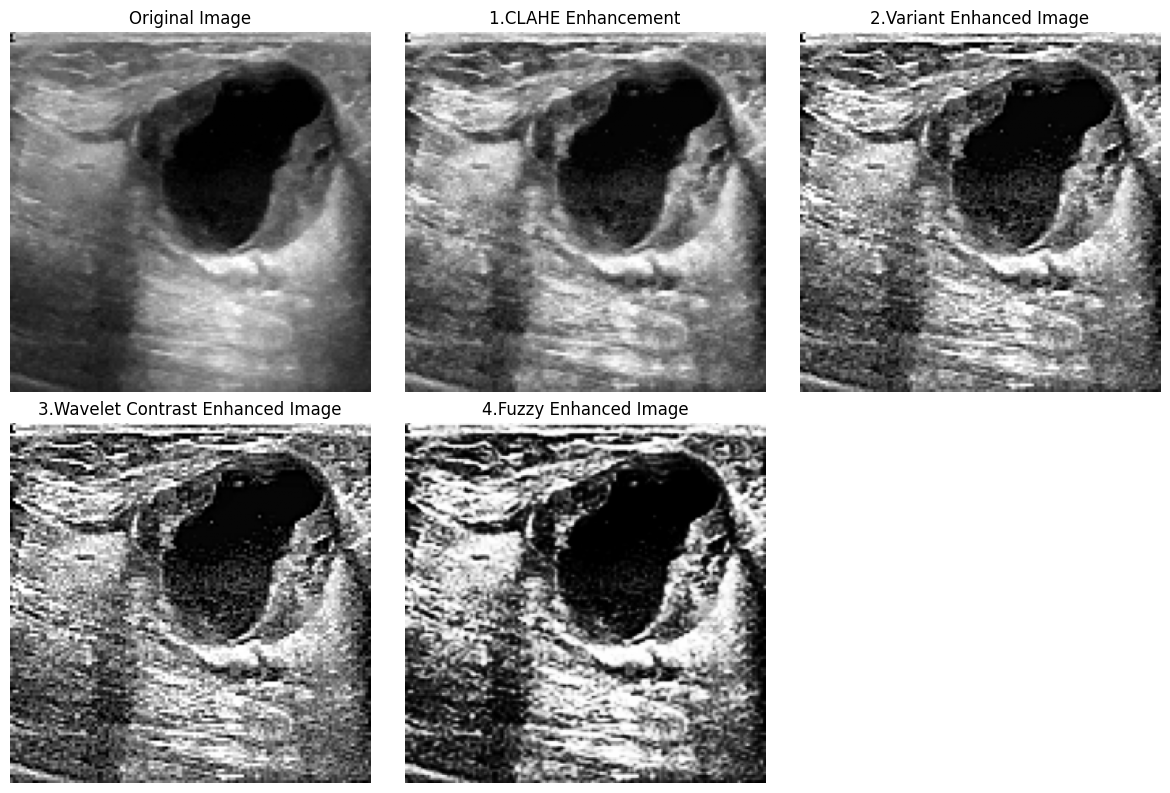

In [6]:
import matplotlib.pyplot as plt


image_path = r"C:\Users\jeeva\OneDrive\Desktop\new_data\renamed_dataset\Benign\Images\benign (409).png"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 8))

clahe_image = apply_clahe(original_image)
variant_enhanced_image = apply_variant_enhancement(clahe_image)
wavelet_contrast_image = apply_wavelet_contrast_enhancement(variant_enhanced_image)
fuzzy_enhanced_image = apply_fuzzy_enhancement(wavelet_contrast_image)

# Original Image (Top-Left)
plt.subplot(2, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Histogram Equalized Image (Top-Middle)
plt.subplot(2, 3, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title("1.CLAHE Enhancement")
plt.axis('off')

# CLAHE Image (Top-Right)
plt.subplot(2, 3, 3)
plt.imshow(variant_enhanced_image, cmap='gray')
plt.title("2.Variant Enhanced Image")
plt.axis('off')

# Variant-Enhanced Image (Bottom-Left)
plt.subplot(2, 3, 4)
plt.imshow(wavelet_contrast_image, cmap='gray')
plt.title("3.Wavelet Contrast Enhanced Image")
plt.axis('off')

# Enhanced Image (Bottom-Middle)
plt.subplot(2, 3, 5)
plt.imshow(fuzzy_enhanced_image, cmap='gray')
plt.title("4.Fuzzy Enhanced Image")
plt.axis("off")


plt.tight_layout()
plt.show()


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

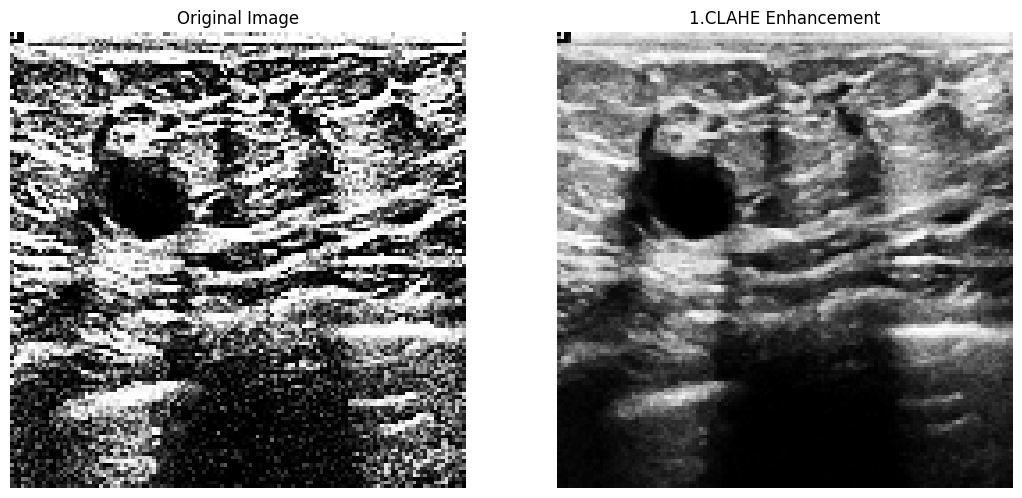

In [41]:
fuzzy_enhanced_image1 = apply_fuzzy_enhancement(original_image)

plt.figure(figsize=(20, 20))
# Original Image (Top-Left)
plt.subplot(2, 3, 1)
plt.imshow(fuzzy_enhanced_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Histogram Equalized Image (Top-Middle)
plt.subplot(2, 3, 2)
plt.imshow(fuzzy_enhanced_image1, cmap='gray')
plt.title("1.CLAHE Enhancement")
plt.axis('off')

In [7]:
def process_image(input_path, output_path):
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    print(input_path)
    if image is None:
        print(f"Warning: Could not read {input_path}")
        return
    
    image = apply_clahe(image)
    image = apply_variant_enhancement(image)
    image = apply_wavelet_contrast_enhancement(image)
    image = apply_fuzzy_enhancement(image)
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, image)

def process_dataset(dataset_path, output_path):
    categories = ["Normal", "Benign", "Malignant"]
    for category in categories:
        for subfolder in ["Images"]:
            input_dir = os.path.join(dataset_path, category, subfolder)
            output_dir = os.path.join(output_path, category, subfolder)
            os.makedirs(output_dir, exist_ok=True)
            print(input_dir)
            print()
            if not os.path.exists(input_dir):
                continue
            
            for image_name in os.listdir(input_dir):
                input_image_path = os.path.join(input_dir, image_name)
                output_image_path = os.path.join(output_dir, image_name)
                
                if subfolder == "Images":
                    process_image(input_image_path, output_image_path)
                else:
                    shutil.copy(input_image_path, output_image_path)  # Copy masks without processing

# Example Usage
#dataset_path = r"C:\Users\jeeva\OneDrive\Desktop\new_data\renamed_dataset"
#output_dataset_path = r"C:\Users\jeeva\OneDrive\Desktop\new_data\final_dataset"
#process_dataset(dataset_path, output_dataset_path)
#print(f"Processed dataset saved at {output_dataset_path}")


In [19]:

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply CLAHE
    image = apply_clahe(image)
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Apply Variant-Enhanced Mechanism
    image = apply_variant_enhancement(image)
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Apply Wavelet Features & Contrast Enhancement
    image = apply_wavelet_contrast_enhancement(image)
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Apply Fuzzy Enhancement (Ensure scaling is correct)
    image = apply_fuzzy_enhancement(image)
    image = (image * 255).clip(0, 255).astype(np.uint8)

    return image

def enhance_dataset(input_dir, output_dir):
    for category in ['Normal', 'Benign', 'Malignant']:
        for subfolder in ['Images', 'Masks']:
            input_path = os.path.join(input_dir, category, subfolder)
            output_path = os.path.join(output_dir, category, subfolder)

            os.makedirs(output_path, exist_ok=True)

            for filename in os.listdir(input_path):
                input_file = os.path.join(input_path, filename)
                output_file = os.path.join(output_path, filename)

                if subfolder == 'Images':
                    # Process and save enhanced image
                    enhanced_image = process_image(input_file)
                    cv2.imwrite(output_file, enhanced_image)
                else:
                    # Copy mask and resize to 224x224x3
                    mask = cv2.imread(input_file)
                    mask_resized = cv2.resize(mask, (224, 224))
                    mask_resized = cv2.cvtColor(mask_resized, cv2.COLOR_GRAY2BGR) if len(mask.shape) == 2 else mask_resized
                    cv2.imwrite(output_file, mask_resized)
input_directory = r"C:\Users\jeeva\OneDrive\Desktop\new_data\renamed_dataset"
output_directory = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_dataset"

enhance_dataset(input_directory, output_directory)

In [ ]:
input_path = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_dataset"
output_path = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_with_augmentation_dataset"


In [3]:
import tensorflow as tf
import os
import cv2
import numpy as np

# ✅ Paths for Input and Output Datasets
input_path = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_dataset"
output_path = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_with_augmentation_dataset"

os.makedirs(output_path, exist_ok=True)

# ✅ Helper Function: Rotate Image
def rotate_image(image, angle):
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    angle_rad = tf.convert_to_tensor(angle * (3.14 / 180), dtype=tf.float32)

    rotation_matrix = tf.stack([
        [tf.cos(angle_rad), -tf.sin(angle_rad), 0],
        [tf.sin(angle_rad), tf.cos(angle_rad), 0],
        [0, 0, 1]
    ])
    image = tf.image.rot90(image, k=int(angle / 90))
    return tf.image.resize_with_crop_or_pad(image, h, w)

# ✅ Augmentation Function (with Mask Handling)
@tf.function
def augment_data(image, mask):
    # Ensure mask is 3D: (128, 128, 1)
    mask = tf.expand_dims(mask, axis=-1)

    # Random Flip (Horizontal and Vertical)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random Rotation (-30 to +30 degrees)
    if tf.random.uniform(()) > 0.5:
        angle = tf.random.uniform((), minval=-30, maxval=30)
        image = rotate_image(image, angle)
        mask = rotate_image(mask, angle)

    # Random Scaling (Zoom In/Out)
    if tf.random.uniform(()) > 0.5:
        scale = tf.random.uniform((), minval=0.8, maxval=1.2)
        new_size = tf.cast(scale * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)

        image = tf.image.resize_with_crop_or_pad(image, 128, 128)
        mask = tf.image.resize_with_crop_or_pad(mask, 128, 128)

    # Random Brightness Adjustment (Images Only)
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random Contrast Adjustment (Images Only)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Ensure mask is 2D again (128, 128)
    mask = tf.squeeze(mask, axis=-1)

    return image, mask

# ✅ Dataset Augmentation Function
def augment_dataset(input_path, output_path, augmentations_per_image=3):
    categories = ['Normal', 'Benign', 'Malignant']

    for category in categories:
        image_dir = os.path.join(input_path, category, 'Images')
        mask_dir = os.path.join(input_path, category, 'Masks')

        output_image_dir = os.path.join(output_path, category, 'Images')
        output_mask_dir = os.path.join(output_path, category, 'Masks')

        os.makedirs(output_image_dir, exist_ok=True)
        os.makedirs(output_mask_dir, exist_ok=True)

        for filename in os.listdir(image_dir):
            img_path = os.path.join(image_dir, filename)

            # ✅ Match Image to Mask
            base_name = filename.replace(".png", "")
            mask_filename = f"{base_name}_mask.png"
            mask_path = os.path.join(mask_dir, mask_filename)

            if not os.path.exists(mask_path):
                print(f"Skipping {filename}: No corresponding mask found.")
                continue

            print(f"Processing: {filename}")

            # ✅ Load and Normalize Image and Mask
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                print(f"Error loading {filename}. Skipping...")
                continue

            # Resize to 128x128
            image = cv2.resize(image, (128, 128))
            mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

            image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0
            mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0

            # ✅ Save Original Image and Mask
            cv2.imwrite(os.path.join(output_image_dir, filename), (image.numpy() * 255).astype(np.uint8))
            cv2.imwrite(os.path.join(output_mask_dir, mask_filename), (mask.numpy() * 255).astype(np.uint8))

            # ✅ Perform Augmentations
            for i in range(augmentations_per_image):
                aug_image, aug_mask = augment_data(image, mask)

                aug_image = (aug_image.numpy() * 255).astype(np.uint8)
                aug_mask = (aug_mask.numpy() * 255).astype(np.uint8)

                # Save augmented outputs
                aug_image_name = f"aug_{i}_{filename}"
                aug_mask_name = f"aug_{i}_{mask_filename}"

                cv2.imwrite(os.path.join(output_image_dir, aug_image_name), aug_image)
                cv2.imwrite(os.path.join(output_mask_dir, aug_mask_name), aug_mask)

            print(f"Completed: {filename}")

    print("✅ Data Augmentation Completed!")

# ✅ Run Augmentation Process
augment_dataset(input_path, output_path)


Processing: normal (1).png
Completed: normal (1).png
Processing: normal (10).png
Completed: normal (10).png
Processing: normal (100).png
Completed: normal (100).png
Processing: normal (101).png
Completed: normal (101).png
Processing: normal (102).png
Completed: normal (102).png
Processing: normal (103).png
Completed: normal (103).png
Processing: normal (104).png
Completed: normal (104).png
Processing: normal (105).png
Completed: normal (105).png
Processing: normal (106).png
Completed: normal (106).png
Processing: normal (107).png
Completed: normal (107).png
Processing: normal (108).png
Completed: normal (108).png
Processing: normal (109).png
Completed: normal (109).png
Processing: normal (11).png
Completed: normal (11).png
Processing: normal (110).png
Completed: normal (110).png
Processing: normal (111).png
Completed: normal (111).png
Processing: normal (112).png
Completed: normal (112).png
Processing: normal (113).png
Completed: normal (113).png
Processing: normal (114).png
Completed:

Verification 

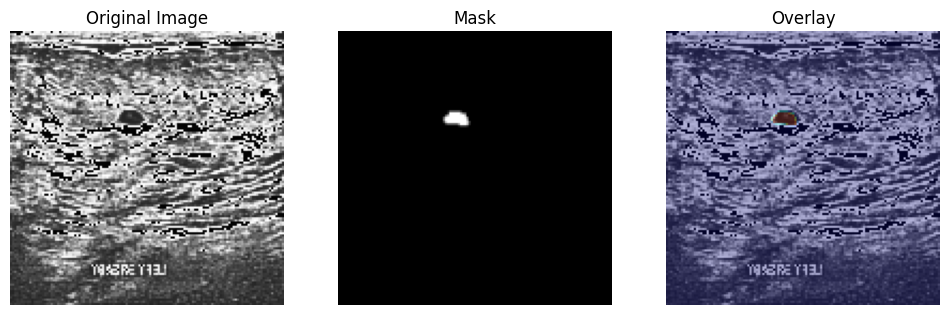

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# ✅ Paths to Images and Masks (Change these paths accordingly)
image_dir = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_with_augmentation_dataset\Benign\Images"
mask_dir = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_with_augmentation_dataset\Benign\Masks"

# ✅ Function to Overlay Image and Mask
def overlay_image_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if images are loaded
    if image is None or mask is None:
        print(f"Error loading: {image_path} or {mask_path}")
        return

    # Ensure image and mask are the same size
    if image.shape[:2] != mask.shape[:2]:
        print(f"Size mismatch: {image_path} and {mask_path}")
        return

    # Overlay mask in red color (on original image)
    mask_overlay = cv2.applyColorMap(mask, cv2.COLORMAP_JET)  # Jet colormap for better visualization
    blended = cv2.addWeighted(image, 0.7, mask_overlay, 0.3, 0)

    # Display original image, mask, and overlay
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# ✅ Verify a Few Random Samples
for filename in os.listdir(image_dir):
    if filename.startswith("aug_"):  # Verify only augmented samples
        image_path = os.path.join(image_dir, filename)

        # Construct corresponding mask path
        mask_filename = filename.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_filename)

        if os.path.exists(mask_path):
            overlay_image_mask(image_path, mask_path)
            break # Visualize one sample, remove this line to visualize all


In [9]:
# ✅ Check for Image-Mask Alignment Issues
def check_alignment(image_dir, mask_dir):
    mismatches = 0
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)

        # Construct corresponding mask path
        mask_filename = filename.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_filename)

        if not os.path.exists(mask_path):
            print(f"Missing mask for {filename}")
            continue

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if dimensions match
        if image.shape[:2] != mask.shape[:2]:
            print(f"Size mismatch: {filename}")
            mismatches += 1

    if mismatches == 0:
        print("✅ All images and masks are aligned properly!")
    else:
        print(f"❌ Found {mismatches} misaligned pairs.")

# ✅ Check Normal, Benign, Malignant categories
for category in ['Normal', 'Benign', 'Malignant']:
    image_dir = os.path.join(output_path, category, 'Images')
    mask_dir = os.path.join(output_path, category, 'Masks')
    print(f"🔎 Checking {category}...")
    check_alignment(image_dir, mask_dir)


🔎 Checking Normal...
✅ All images and masks are aligned properly!
🔎 Checking Benign...
✅ All images and masks are aligned properly!
🔎 Checking Malignant...
✅ All images and masks are aligned properly!


Dataset split and augmentation complete!


In [1]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def create_output_dirs(base_dir):
    subsets = ['train', 'val', 'test']
    categories = ['Normal', 'Benign', 'Malignant']
    for subset in subsets:
        for category in categories:
            os.makedirs(os.path.join(base_dir, subset, category, 'Images'), exist_ok=True)
            os.makedirs(os.path.join(base_dir, subset, category, 'Masks'), exist_ok=True)

def get_image_mask_pairs(dataset_dir):
    pairs = []
    categories = ['Normal', 'Benign', 'Malignant']

    for category in categories:
        img_dir = os.path.join(dataset_dir, category, 'Images')
        mask_dir = os.path.join(dataset_dir, category, 'Masks')

        img_files = sorted(os.listdir(img_dir))
        mask_files = sorted(os.listdir(mask_dir))

        for img_file, mask_file in zip(img_files, mask_files):
            pairs.append((os.path.join(img_dir, img_file), os.path.join(mask_dir, mask_file), category))

    return pairs

def split_data(pairs, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    random.shuffle(pairs)
    total = len(pairs)

    train_split = int(total * train_ratio)
    val_split = train_split + int(total * val_ratio)

    train_pairs = pairs[:train_split]
    val_pairs = pairs[train_split:val_split]
    test_pairs = pairs[val_split:]

    return train_pairs, val_pairs, test_pairs

def augment_data(image, mask):
    # Random Flip (Horizontal and Vertical)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random Rotation (-30 to 30 degrees) without TFA
    if tf.random.uniform(()) > 0.5:
        angle = tf.random.uniform((), minval=-30, maxval=30) * (3.1416 / 180.0)
        image = tf.keras.preprocessing.image.random_rotation(image, angle)
        mask = tf.keras.preprocessing.image.random_rotation(mask, angle)

    # Random Scaling (Zoom In/Out)
    if tf.random.uniform(()) > 0.5:
        scale = tf.random.uniform((), minval=0.8, maxval=1.2)
        new_size = tf.cast(scale * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)
        image = tf.image.resize_with_crop_or_pad(image, 128, 128)
        mask = tf.image.resize_with_crop_or_pad(mask, 128, 128)

    # Random Brightness & Contrast Adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, mask

def save_image_mask(image, mask, img_path, mask_path):
    array_to_img(image).save(img_path)
    array_to_img(mask).save(mask_path)
def process_and_save(pairs, output_dir, subset, augment=False):
    for img_path, mask_path, category in pairs:
        image = img_to_array(load_img(img_path))
        mask = img_to_array(load_img(mask_path, color_mode='grayscale'))

        img_output_path = os.path.join(output_dir, subset, category, 'Images', os.path.basename(img_path))
        mask_output_path = os.path.join(output_dir, subset, category, 'Masks', os.path.basename(mask_path))

        save_image_mask(image, mask, img_output_path, mask_output_path)

        # If augmenting, save additional augmented images for training
        if augment and subset == 'train':
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            mask = tf.convert_to_tensor(mask, dtype=tf.float32)
            aug_image, aug_mask = augment_data(image, mask)

            aug_img_name = f"aug_{os.path.basename(img_path)}"
            aug_mask_name = f"aug_{os.path.basename(mask_path)}"

            aug_img_output_path = os.path.join(output_dir, subset, category, 'Images', aug_img_name)
            aug_mask_output_path = os.path.join(output_dir, subset, category, 'Masks', aug_mask_name)

            save_image_mask(aug_image, aug_mask, aug_img_output_path, aug_mask_output_path)

# Paths
input_dir = r"C:\Users\jeeva\OneDrive\Desktop\new_data\enhanced_dataset"  # Path to your enhanced dataset
output_dir = r"C:\Users\jeeva\OneDrive\Desktop\new_data\train_test_validation"  # Where to store the new dataset

# Ensure output directories exist
create_output_dirs(output_dir)

# Load and split dataset
pairs = get_image_mask_pairs(input_dir)
train_pairs, val_pairs, test_pairs = split_data(pairs)

# Process and save datasets
process_and_save(train_pairs, output_dir, 'train', augment=True)  # Augment training data
process_and_save(val_pairs, output_dir, 'val', augment=False)     # Validation (no augmentation)
process_and_save(test_pairs, output_dir, 'test', augment=False)   # Test (no augmentation)

print("Dataset split and augmentation complete!")


Dataset split and augmentation complete!
